In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import re
from sklearn.model_selection import cross_val_score  #交叉验证
from sklearn.svm import SVC  #支持向量机
from sklearn.metrics import accuracy_score  #混淆矩阵准确度
from sklearn.metrics import classification_report  #混淆矩阵分类性能评估报告
from sklearn.metrics import confusion_matrix    #混淆矩阵数组

## 说明：年龄不均衡类别的特殊采样处理
本程序基于P6程序中对年龄分类的特殊采样处理必要性探究的基础上，对dlib库128维特征距离数据集使用了以下六种特殊采样处理方法并对比其分类器性能；

经对比发现SMOTE过采样处理的效果最好，但实际效果也不是很理想，故又对剩余三种数据集，即PCA特征降维数据集、LBP图像直方图特征数据集、LBP图像PCA降维数据集进行SMOTE过采样处理后，对比四种数据集的分类器性能。

## 导入数据

In [42]:
#读取数据集：dlib处理的128维特征距离数据集Distance，以及PCA特征降维后的128为特征脸数据集PCA
trainDistance = np.load("data/trainDistance.npy")
testDistance = np.load("data/testDistance.npy")
trainPCA = np.load("data/trainPCA.npy")
testPCA = np.load("data/testPCA.npy")
trainLBP_PCA = np.load("data/trainLBP_PCA.npy")
testLBP_PCA = np.load("data/testLBP_PCA.npy")
trainLBP = np.load("data/trainLBP.npy")
testLBP = np.load("data/testLBP.npy")

print("trainDistance.shape = ",trainDistance.shape)
print("testDistance.shape = ",trainDistance.shape)
print("trainPCA.shape = ",trainDistance.shape)
print("testPCA.shape = ",trainDistance.shape)
print("trainLBP_PCA.shape = ",trainLBP_PCA.shape)
print("testLBP_PCA.shape = ",trainLBP_PCA.shape)
print("trainLBP.shape = ",trainLBP.shape)
print("testLBP.shape = ",trainLBP.shape)
print()

#读取标签，map为数值化标签
DS_sex_map = np.load("data/DS_sex_map.npy")
DR_sex_map = np.load("data/DR_sex_map.npy")
DS_age_map = np.load("data/DS_age_map.npy")
DR_age_map = np.load("data/DR_age_map.npy")
DS_sex = np.load("data/DS_sex.npy",allow_pickle=True)
DR_sex = np.load("data/DR_sex.npy",allow_pickle=True)
DS_age = np.load("data/DS_age.npy",allow_pickle=True)
DR_age = np.load("data/DR_age.npy",allow_pickle=True)
print("DR_sex_map: ", DR_sex_map)
print("DS_sex_map: ", DS_sex_map)
print("DR_age_map: ", DR_age_map)
print("DS_age_map: ", DS_age_map)
print("DR_sex: ", DR_sex)
print("DS_sex: ", DS_sex)
print("DR_age: ", DR_age)
print("DS_age: ", DS_age)

trainDistance.shape =  (1995, 128)
testDistance.shape =  (1995, 128)
trainPCA.shape =  (1995, 128)
testPCA.shape =  (1995, 128)
trainLBP_PCA.shape =  (1995, 128)
testLBP_PCA.shape =  (1995, 128)
trainLBP.shape =  (1995, 128)
testLBP.shape =  (1995, 128)

DR_sex_map:  [1 1 1 ... 0 0 0]
DS_sex_map:  [0 0 1 ... 0 0 0]
DR_age_map:  [0 0 0 ... 2 3 3]
DS_age_map:  [3 2 3 ... 2 2 2]
DR_sex:  ['male' 'male' 'male' ... 'female' 'female' 'female']
DS_sex:  ['female' 'female' 'male' ... 'female' 'female' 'female']
DR_age:  ['child' 'child' 'child' ... 'adult' 'senior' 'senior']
DS_age:  ['senior' 'adult' 'senior' ... 'adult' 'adult' 'adult']


## 1. dlib数据集+过采样

#### 1) ros法-RandomOverSample随机过采样

In [4]:
from imblearn.over_sampling import RandomOverSampler
imb_ros = RandomOverSampler(random_state = 0)
trainDistance_ros, DR_age_ros = imb_ros.fit_resample(trainDistance, DR_age)

In [5]:
trainDistance_ros.shape

(5744, 128)

In [6]:
ros_age_dataframe = pd.DataFrame(data =  {'age':DR_age_ros})
#print(ros_age_dataframe)
ros_age_count = ros_age_dataframe['age'].value_counts()
print(ros_age_count)

child     1436
adult     1436
teen      1436
senior    1436
Name: age, dtype: int64


In [11]:
#采用sklearn.svm.SVC，类似的有sklearn.svm.LinearSVC

clf_ovoLinear_ros = SVC(kernel='linear', decision_function_shape='ovo')
clf_ovoLinear_ros.fit(trainDistance_ros, DR_age_ros)

SVC(decision_function_shape='ovo', kernel='linear')

In [12]:
ovoLinear_ros_age_pre = clf_ovoLinear_ros.predict(testDistance)
ovoLinear_ros_accuracy = accuracy_score(DS_age, ovoLinear_ros_age_pre)
print('ovoLinear_ros_accuracy = ', ovoLinear_ros_accuracy)
print('分类结果报告：', '\n', classification_report(DS_age, ovoLinear_ros_age_pre))

ovoLinear_ros_accuracy =  0.7995991983967936
分类结果报告： 
               precision    recall  f1-score   support

       adult       0.96      0.82      0.89      1730
       child       0.52      0.65      0.58        68
      senior       0.55      0.75      0.63       115
        teen       0.15      0.48      0.23        83

    accuracy                           0.80      1996
   macro avg       0.54      0.68      0.58      1996
weighted avg       0.89      0.80      0.83      1996



#### 2) SMOTE过采样

In [21]:
from imblearn.over_sampling import SMOTE
imb_SMOTE = SMOTE(random_state = 0)
trainDistance_SMOTE, DR_age_SMOTE = imb_SMOTE.fit_resample(trainDistance, DR_age)
trainDistance_SMOTE.shape

(5744, 128)

In [17]:
SMOTE_age_dataframe = pd.DataFrame(data =  {'age':DR_age_SMOTE})
#print(ros_age_dataframe)
SMOTE_age_count = SMOTE_age_dataframe['age'].value_counts()
print(SMOTE_age_count)

child     1436
adult     1436
teen      1436
senior    1436
Name: age, dtype: int64


In [19]:
#采用sklearn.svm.SVC，类似的有sklearn.svm.LinearSVC

clf_ovoLinear_SMOTE = SVC(kernel='linear')
clf_ovoLinear_SMOTE.fit(trainDistance_SMOTE, DR_age_SMOTE)

SVC(kernel='linear')

In [20]:
ovoLinear_SMOTE_age_pre = clf_ovoLinear_SMOTE.predict(testDistance)
ovoLinear_SMOTE_accuracy = accuracy_score(DS_age, ovoLinear_SMOTE_age_pre)
print('ovoLinear_SMOTE_accuracy = ', ovoLinear_SMOTE_accuracy)
print('分类结果报告：', '\n', classification_report(DS_age, ovoLinear_SMOTE_age_pre))

ovoLinear_SMOTE_accuracy =  0.844689378757515
分类结果报告： 
               precision    recall  f1-score   support

       adult       0.96      0.88      0.92      1730
       child       0.62      0.63      0.63        68
      senior       0.56      0.75      0.64       115
        teen       0.21      0.49      0.29        83

    accuracy                           0.84      1996
   macro avg       0.59      0.69      0.62      1996
weighted avg       0.90      0.84      0.87      1996



#### 3) BorderlineSOMTE过采样

In [13]:
from imblearn.over_sampling import BorderlineSMOTE
imb_BS = BorderlineSMOTE(random_state=0,k_neighbors = 5,kind="borderline-1")
trainDistance_BS, DR_age_BS = imb_BS.fit_resample(trainDistance, DR_age)
trainDistance_BS.shape

(5744, 128)

In [14]:
BS_age_dataframe = pd.DataFrame(data =  {'age':DR_age_BS})
#print(BS_age_dataframe)
BS_age_count = BS_age_dataframe['age'].value_counts()
print(BS_age_count)

child     1436
adult     1436
teen      1436
senior    1436
Name: age, dtype: int64


In [15]:
#采用sklearn.svm.SVC，类似的有sklearn.svm.LinearSVC

clf_ovoLinear_BS = SVC(kernel='linear')
clf_ovoLinear_BS.fit(trainDistance_BS, DR_age_BS)

SVC(kernel='linear')

In [16]:
ovoLinear_BS_age_pre = clf_ovoLinear_BS.predict(testDistance)
ovoLinear_BS_accuracy = accuracy_score(DS_age, ovoLinear_BS_age_pre)
print('ovoLinear_BS_accuracy = ', ovoLinear_BS_accuracy)
print('分类结果报告：', '\n', classification_report(DS_age, ovoLinear_BS_age_pre))

ovoLinear_BS_accuracy =  0.8476953907815631
分类结果报告： 
               precision    recall  f1-score   support

       adult       0.96      0.88      0.92      1730
       child       0.49      0.79      0.60        68
      senior       0.56      0.73      0.63       115
        teen       0.21      0.37      0.26        83

    accuracy                           0.85      1996
   macro avg       0.55      0.69      0.61      1996
weighted avg       0.89      0.85      0.86      1996



#### 4) ADASYN自适应合成抽样

In [17]:
from imblearn.over_sampling import ADASYN
imb_ADA = ADASYN(random_state=0,n_neighbors=5)
trainDistance_ADA, DR_age_ADA = imb_ADA.fit_resample(trainDistance, DR_age)
trainDistance_ADA.shape

(5733, 128)

In [18]:
ADA_age_dataframe = pd.DataFrame(data =  {'age':DR_age_BS})
#print(ADA_age_dataframe)
ADA_age_count = ADA_age_dataframe['age'].value_counts()
print(ADA_age_count)

child     1436
adult     1436
teen      1436
senior    1436
Name: age, dtype: int64


In [23]:
#采用sklearn.svm.SVC，类似的有sklearn.svm.LinearSVC

clf_ovoLinear_ADA = SVC(kernel='linear')
clf_ovoLinear_ADA.fit(trainDistance_ADA, DR_age_ADA)

SVC(kernel='linear')

In [24]:
ovoLinear_ADA_age_pre = clf_ovoLinear_ADA.predict(testDistance)
ovoLinear_ADA_accuracy = accuracy_score(DS_age, ovoLinear_ADA_age_pre)
print('ovoLinear_ADA_accuracy = ', ovoLinear_ADA_accuracy)
print('分类结果报告：', '\n', classification_report(DS_age, ovoLinear_ADA_age_pre))

ovoLinear_ADA_accuracy =  0.8361723446893787
分类结果报告： 
               precision    recall  f1-score   support

       adult       0.96      0.87      0.91      1730
       child       0.55      0.72      0.62        68
      senior       0.55      0.75      0.63       115
        teen       0.19      0.45      0.27        83

    accuracy                           0.84      1996
   macro avg       0.56      0.69      0.61      1996
weighted avg       0.89      0.84      0.86      1996



#### 5) KMeansSOMTE过采样

In [28]:
from imblearn.over_sampling import KMeansSMOTE
from sklearn.cluster import MiniBatchKMeans
imb_KMS = KMeansSMOTE(kmeans_estimator=MiniBatchKMeans(n_init=4, random_state=0), random_state=0, k_neighbors=3)
trainDistance_KMS, DR_age_KMS = imb_KMS.fit_resample(trainDistance, DR_age)
trainDistance_KMS.shape

C:\Users\Rama\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Users\Rama\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


RuntimeError: No clusters found with sufficient samples of class senior. Try lowering the cluster_balance_threshold or increasing the number of clusters.

In [22]:
KMS_age_dataframe = pd.DataFrame(data =  {'age':DR_age_KMS})
#print(KMS_age_dataframe)
KMS_age_count = KMS_age_dataframe['age'].value_counts()
print(KMS_age_count)

NameError: name 'DR_age_KMS' is not defined

In [ ]:
#采用sklearn.svm.SVC，类似的有sklearn.svm.LinearSVC

clf_ovoLinear_SMOTE = SVC(kernel='linear')
clf_ovoLinear_SMOTE.fit(trainDistance_SMOTE, DR_age_SMOTE)

In [ ]:
ovoLinear_SMOTE_age_pre = clf_ovoLinear_SMOTE.predict(testDistance)
ovoLinear_SMOTE_accuracy = accuracy_score(DS_age, ovoLinear_SMOTE_age_pre)
print('ovoLinear_SMOTE_accuracy = ', ovoLinear_SMOTE_accuracy)
print('分类结果报告：', '\n', classification_report(DS_age, ovoLinear_SMOTE_age_pre))

## 2. dlib数据集+欠采样

#### 1) rus法-RandomUnderSampler随机欠采样

In [8]:
from imblearn.under_sampling import RandomUnderSampler
imb_rus = RandomUnderSampler(random_state = 0)
trainDistance_rus, DR_age_rus = imb_rus.fit_resample(trainDistance, DR_age)

In [9]:
trainDistance_rus.shape

(216, 128)

In [14]:
rus_age_dataframe = pd.DataFrame(data =  {'age':DR_age_rus})
print(rus_age_dataframe)
rus_age_count = rus_age_dataframe['age'].value_counts()
print(rus_age_count)

       age
0    adult
1    adult
2    adult
3    adult
4    adult
..     ...
211   teen
212   teen
213   teen
214   teen
215   teen

[216 rows x 1 columns]
adult     54
child     54
senior    54
teen      54
Name: age, dtype: int64


In [10]:
#采用sklearn.svm.SVC，类似的有sklearn.svm.LinearSVC

clf_ovoLinear_rus = SVC(kernel='linear')
clf_ovoLinear_rus.fit(trainDistance_rus, DR_age_rus)

SVC(kernel='linear')

In [11]:
ovoLinear_rus_age_pre = clf_ovoLinear_rus.predict(testDistance)
ovoLinear_rus_accuracy = accuracy_score(DS_age, ovoLinear_rus_age_pre)
print('ovoLinear_rus_accuracy = ', ovoLinear_rus_accuracy)
print('分类结果报告：', '\n', classification_report(DS_age, ovoLinear_rus_age_pre))

ovoLinear_rus_accuracy =  0.6903807615230461
分类结果报告： 
               precision    recall  f1-score   support

       adult       0.97      0.70      0.81      1730
       child       0.44      0.72      0.54        68
      senior       0.37      0.83      0.51       115
        teen       0.07      0.33      0.12        83

    accuracy                           0.69      1996
   macro avg       0.46      0.64      0.50      1996
weighted avg       0.88      0.69      0.75      1996



#### 2) ClusterCentroids欠采样

In [5]:
from imblearn.under_sampling import ClusterCentroids
imb_CC = ClusterCentroids(random_state = 0)
trainDistance_CC, DR_age_CC = imb_CC.fit_resample(trainDistance, DR_age)
trainDistance_CC.shape

(216, 128)

In [6]:
CC_age_dataframe = pd.DataFrame(data =  {'age':DR_age_CC})
CC_age_count = CC_age_dataframe['age'].value_counts()
print(CC_age_count)

adult     54
child     54
senior    54
teen      54
Name: age, dtype: int64


In [7]:
#采用sklearn.svm.SVC，类似的有sklearn.svm.LinearSVC

clf_ovoLinear_CC = SVC(kernel='linear')
clf_ovoLinear_CC.fit(trainDistance_CC, DR_age_CC)

SVC(kernel='linear')

In [8]:
ovoLinear_CC_age_pre = clf_ovoLinear_CC.predict(testDistance)
ovoLinear_CC_accuracy = accuracy_score(DS_age, ovoLinear_CC_age_pre)
print('ovoLinear_CC_accuracy = ', ovoLinear_CC_accuracy)
print('分类结果报告：', '\n', classification_report(DS_age, ovoLinear_CC_age_pre))

ovoLinear_CC_accuracy =  0.6783567134268537
分类结果报告： 
               precision    recall  f1-score   support

       adult       0.97      0.68      0.80      1730
       child       0.35      0.81      0.49        68
      senior       0.37      0.86      0.52       115
        teen       0.09      0.39      0.14        83

    accuracy                           0.68      1996
   macro avg       0.45      0.68      0.49      1996
weighted avg       0.88      0.68      0.74      1996



In [23]:
from imblearn.combine import SMOTETomek
imb_SMOTETomek =SMOTETomek(random_state=0)
trainDistance_SMOTETomek, DR_age_SMOTETomek = imb_SMOTETomek.fit_resample(trainDistance, DR_age)
trainDistance_SMOTETomek.shape

(5744, 128)

In [24]:
SMOTETomek_age_dataframe = pd.DataFrame(data =  {'age':DR_age_SMOTETomek})
#print(SMOTETomek_age_dataframe)
SMOTETomek_age_count = SMOTETomek_age_dataframe['age'].value_counts()
print(SMOTETomek_age_count)

child     1436
adult     1436
teen      1436
senior    1436
Name: age, dtype: int64


In [25]:
#采用sklearn.svm.SVC，类似的有sklearn.svm.LinearSVC

clf_ovoLinear_SMOTETomek = SVC(kernel='linear')
clf_ovoLinear_SMOTETomek.fit(trainDistance_SMOTETomek, DR_age_SMOTETomek)

SVC(kernel='linear')

In [26]:
ovoLinear_SMOTETomek_age_pre = clf_ovoLinear_SMOTETomek.predict(testDistance)
ovoLinear_SMOTETomek_accuracy = accuracy_score(DS_age, ovoLinear_SMOTETomek_age_pre)
print('ovoLinear_SMOTETomek_accuracy = ', ovoLinear_SMOTETomek_accuracy)
print('分类结果报告：', '\n', classification_report(DS_age, ovoLinear_SMOTETomek_age_pre))

ovoLinear_SMOTETomek_accuracy =  0.844689378757515
分类结果报告： 
               precision    recall  f1-score   support

       adult       0.96      0.88      0.92      1730
       child       0.62      0.63      0.63        68
      senior       0.56      0.75      0.64       115
        teen       0.21      0.49      0.29        83

    accuracy                           0.84      1996
   macro avg       0.59      0.69      0.62      1996
weighted avg       0.90      0.84      0.87      1996



## 3. PCA数据集 + SMOTE

In [29]:
from imblearn.over_sampling import SMOTE
PCAimb_SMOTE = SMOTE(random_state = 0)
trainPCA_SMOTE, DR_PCA_age_SMOTE = PCAimb_SMOTE.fit_resample(trainPCA, DR_age)
trainPCA_SMOTE.shape

(5744, 128)

In [30]:
SMOTE_age_dataframe = pd.DataFrame(data =  {'age':DR_PCA_age_SMOTE})
#print(ros_age_dataframe)
SMOTE_age_count = SMOTE_age_dataframe['age'].value_counts()
print(SMOTE_age_count)

child     1436
adult     1436
teen      1436
senior    1436
Name: age, dtype: int64


In [31]:
#采用sklearn.svm.SVC，类似的有sklearn.svm.LinearSVC

clf_PCA_ovoLinear_SMOTE = SVC(kernel='linear')
clf_PCA_ovoLinear_SMOTE.fit(trainPCA_SMOTE, DR_PCA_age_SMOTE)

SVC(kernel='linear')

In [32]:
ovoLinear_PCA_SMOTE_age_pre = clf_PCA_ovoLinear_SMOTE.predict(testPCA)
ovoLinear_PCA_SMOTE_accuracy = accuracy_score(DS_age, ovoLinear_PCA_SMOTE_age_pre)
print('ovoLinear_PCA_SMOTE_accuracy = ', ovoLinear_PCA_SMOTE_accuracy)
print('分类结果报告：', '\n', classification_report(DS_age, ovoLinear_PCA_SMOTE_age_pre))

ovoLinear_PCA_SMOTE_accuracy =  0.7950901803607214
分类结果报告： 
               precision    recall  f1-score   support

       adult       0.90      0.88      0.89      1730
       child       0.46      0.25      0.32        68
      senior       0.20      0.32      0.25       115
        teen       0.12      0.12      0.12        83

    accuracy                           0.80      1996
   macro avg       0.42      0.39      0.40      1996
weighted avg       0.81      0.80      0.80      1996



## 4. LBP_PCA数据集 + SMOTE

In [30]:
from sklearn.preprocessing import StandardScaler    #数据标准化
LBP_PCA_SD = StandardScaler()
LBP_PCA_SD.fit(trainLBP_PCA)
trainLBP_PCA_std = LBP_PCA_SD.transform(trainLBP_PCA)
testLBP_PCA_std = LBP_PCA_SD.transform(testLBP_PCA)

In [31]:
from imblearn.over_sampling import SMOTE
LBP_PCAimb_SMOTE = SMOTE(random_state = 0)
trainLBP_PCA_SMOTE, DR_LBP_PCA_age_SMOTE = LBP_PCAimb_SMOTE.fit_resample(trainLBP_PCA_std, DR_age)
trainLBP_PCA_SMOTE.shape

(5744, 128)

In [32]:
SMOTE_age_dataframe = pd.DataFrame(data =  {'age':DR_LBP_PCA_age_SMOTE})
#print(ros_age_dataframe)
SMOTE_age_count = SMOTE_age_dataframe['age'].value_counts()
print(SMOTE_age_count)

child     1436
adult     1436
teen      1436
senior    1436
Name: age, dtype: int64


In [33]:
#采用sklearn.svm.SVC，类似的有sklearn.svm.LinearSVC

clf_LBP_PCA_ovoLinear_SMOTE = SVC(kernel='linear')
clf_LBP_PCA_ovoLinear_SMOTE.fit(trainLBP_PCA_SMOTE, DR_LBP_PCA_age_SMOTE)

SVC(kernel='linear')

In [34]:
ovoLinear_LBP_PCA_SMOTE_age_pre = clf_LBP_PCA_ovoLinear_SMOTE.predict(testLBP_PCA_std)
ovoLinear_LBP_PCA_SMOTE_accuracy = accuracy_score(DS_age, ovoLinear_LBP_PCA_SMOTE_age_pre)
print('ovoLinear_LBP_PCA_SMOTE_accuracy = ', ovoLinear_LBP_PCA_SMOTE_accuracy)
print('分类结果报告：', '\n', classification_report(DS_age, ovoLinear_LBP_PCA_SMOTE_age_pre))

ovoLinear_LBP_PCA_SMOTE_accuracy =  0.8722444889779559
分类结果报告： 
               precision    recall  f1-score   support

       adult       0.89      0.99      0.94      1730
       child       0.03      0.01      0.02        68
      senior       0.83      0.22      0.34       115
        teen       0.00      0.00      0.00        83

    accuracy                           0.87      1996
   macro avg       0.44      0.31      0.33      1996
weighted avg       0.82      0.87      0.84      1996



LBP_ovoLinear_SMOTE混淆矩阵如下：



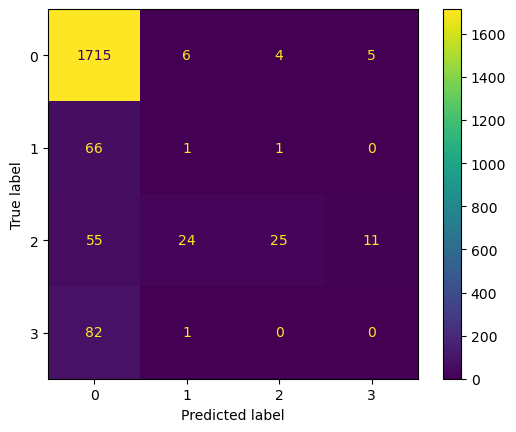

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay
cfm_LBP_PCA_ovoLinear_SMOTE = confusion_matrix(DS_age, ovoLinear_LBP_PCA_SMOTE_age_pre)
print('LBP_ovoLinear_SMOTE混淆矩阵如下：\n')
cfm_LBP_PCA_ovoLinear_SMOTE_display = ConfusionMatrixDisplay(cfm_LBP_PCA_ovoLinear_SMOTE).plot()

上图中0 = adult， 1 = child， 2 = senior， 3 = teen

## 5. LBPH数据集 + SMOTE

In [37]:
from sklearn.preprocessing import StandardScaler    #数据标准化
LBP_SD = StandardScaler()
LBP_SD.fit(trainLBP)
trainLBP_std = LBP_SD.transform(trainLBP)
testLBP_std = LBP_SD.transform(testLBP)

In [38]:
from imblearn.over_sampling import SMOTE
LBPimb_SMOTE = SMOTE(random_state = 0)
trainLBP_SMOTE, DR_LBP_age_SMOTE = LBPimb_SMOTE.fit_resample(trainLBP_std, DR_age)
trainLBP_SMOTE.shape

(5744, 128)

In [39]:
#采用sklearn.svm.SVC，类似的有sklearn.svm.LinearSVC

clf_LBP_ovoLinear_SMOTE = SVC(kernel='linear')
clf_LBP_ovoLinear_SMOTE.fit(trainLBP_SMOTE, DR_LBP_age_SMOTE)

SVC(kernel='linear')

In [40]:
ovoLinear_LBP_SMOTE_age_pre = clf_LBP_ovoLinear_SMOTE.predict(testLBP_std)
ovoLinear_LBP_SMOTE_accuracy = accuracy_score(DS_age, ovoLinear_LBP_SMOTE_age_pre)
print('ovoLinear_LBP_SMOTE_accuracy = ', ovoLinear_LBP_SMOTE_accuracy)
print('分类结果报告：', '\n', classification_report(DS_age, ovoLinear_LBP_SMOTE_age_pre))

ovoLinear_LBP_SMOTE_accuracy =  0.6412825651302605
分类结果报告： 
               precision    recall  f1-score   support

       adult       0.89      0.70      0.78      1730
       child       0.07      0.24      0.11        68
      senior       0.23      0.37      0.28       115
        teen       0.03      0.07      0.04        83

    accuracy                           0.64      1996
   macro avg       0.30      0.34      0.30      1996
weighted avg       0.79      0.64      0.70      1996



LBP_ovoLinear_SMOTE混淆矩阵如下：



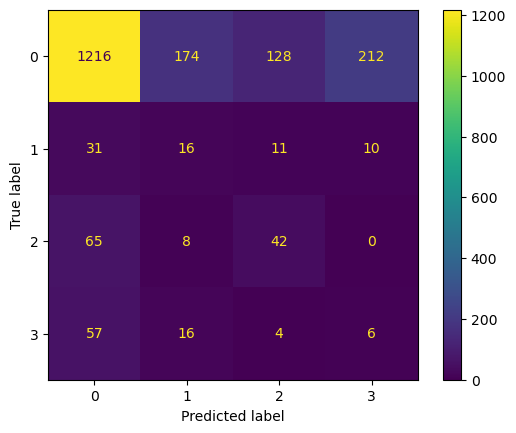

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay
cfm_LBP_ovoLinear_SMOTE = confusion_matrix(DS_age, ovoLinear_LBP_SMOTE_age_pre)
print('LBP_ovoLinear_SMOTE混淆矩阵如下：\n')
cfm_LBP_ovoLinear_SMOTE_display = ConfusionMatrixDisplay(cfm_LBP_ovoLinear_SMOTE).plot()

上图中0 = adult， 1 = child， 2 = senior， 3 = teen